<a href="https://colab.research.google.com/github/sabers13/Parameter-Estimation-of-Black-Hole-Binary-Waveforms-using-BayesFlow/blob/main/SBI_gw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pycbc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [ ]:
!pip install -q bayesflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.4/408.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 107.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
import bayesflow
print(bayesflow.__version__)

INFO:bayesflow:Using backend 'tensorflow'


2.0.6


In [ ]:
%%writefile priors.py

#!/usr/bin/env python
"""
priors_basic.py
---------------
Sample BBH parameters exactly as specified:

* m1  :  Uniform or power-law on [5, 80] M⊙
* m2  :  Uniform on [m_min, m1]  ⇒  always  m2 ≤ m1
* chi :  Uniform on [0, 0.99]   (dimensionless spin magnitude)
* D   :  Uniform in comoving volume  (∝ D²) on [100, 2000] Mpc
* inc :  Isotropic  ⇒ cos ι ~ U(−1, 1)

Return value is a float32 `pandas.DataFrame` with the canonical column order
(m1, m2, chi1, chi2, D, inc).
"""

from __future__ import annotations
import numpy as np
import pandas as pd


def sample_prior(
    n_samples: int,
    *,
    alpha: float = 0.0,          # 0 → uniform; >0 → p(m1) ∝ m1^{−α}
    m_min: float = 5.0,
    m_max: float = 80.0,
    D_min: float = 100.0,
    D_max: float = 2_000.0,
    rng_seed: int | None = None,
) -> pd.DataFrame:
    rng = np.random.default_rng(rng_seed)

    # --- primary mass  m1 ---------------------------------------
    if np.isclose(alpha, 0.0):
        m1 = rng.uniform(m_min, m_max, n_samples)
    else:
        expo = 1.0 - alpha
        u    = rng.random(n_samples)
        m1   = (u * (m_max**expo - m_min**expo) + m_min**expo) ** (1.0 / expo)

    # --- secondary mass  m2  (uniform in [m_min, m1]) -----------
    m2 = rng.uniform(m_min, m1)

    # --- dimensionless spins  -----------------------------------
    chi1 = rng.uniform(0.0, 0.99, n_samples)
    chi2 = rng.uniform(0.0, 0.99, n_samples)

    # --- luminosity distance  D  (uniform in volume) ------------
    uV  = rng.random(n_samples)
    D   = (D_min**3 + uV * (D_max**3 - D_min**3)) ** (1.0 / 3.0)

    # --- inclination  inc  (isotropic) --------------------------
    inc = np.arccos(rng.uniform(-1.0, 1.0, n_samples))

    return pd.DataFrame({
        "m1":   m1.astype(np.float32),
        "m2":   m2.astype(np.float32),
        "chi1": chi1.astype(np.float32),
        "chi2": chi2.astype(np.float32),
        "D":    D.astype(np.float32),
        "inc":  inc.astype(np.float32),
    })


# quick demo when run as a script
if __name__ == "__main__":
    df = sample_prior(5, alpha=1.6, rng_seed=0).round(3)
    print(df)


Writing priors.py


In [ ]:
%%writefile simulator.py
#!/usr/bin/env python
# simulator.py  –  float32-strict, PSD-safe, no precision mismatch

from __future__ import annotations
import numpy as np, pandas as pd
from pycbc.waveform import get_td_waveform
from pycbc.noise    import noise_from_psd
from pycbc.psd      import aLIGOZeroDetHighPower
from pycbc.types    import TimeSeries, FrequencySeries

# ───────── constants ─────────
DELTA_T  = np.float32(1 / 4096)
DURATION = np.float32(8.0)
F_LOWER  = 40.0
APPROX   = "IMRPhenomD"
PSD_FLOW = 20.0

N        = int(DURATION / DELTA_T)
DELTA_F  = 1.0 / DURATION

# ───────── helpers ─────────
def _make_psd(n_freq: int) -> FrequencySeries:
    return aLIGOZeroDetHighPower(n_freq, DELTA_F, PSD_FLOW)

def _whiten(ts: TimeSeries, cal: float) -> TimeSeries:
    fd        = ts.to_frequencyseries()
    psd64     = _make_psd(len(fd)).numpy()
    psd64[psd64 < 1e-40] = 1e-40
    white_fd  = fd.numpy() / np.sqrt(psd64.astype(np.float32))
    white_fd *= np.sqrt(N * DELTA_F) / 2.0
    ts_white  = FrequencySeries(
        white_fd.astype(np.complex64), delta_f=fd.delta_f, copy=False
    ).to_timeseries()
    return TimeSeries(ts_white.numpy().astype(np.float32),
                      delta_t=ts_white.delta_t) * cal

def _optimal_snr(h: TimeSeries) -> float:
    h_fd  = h.to_frequencyseries()
    psd   = _make_psd(len(h_fd)).numpy()
    psd[psd < 1e-40] = 1e-40
    snr_sq = 4.0 * ((np.abs(h_fd.numpy()) ** 2) / psd).sum() * DELTA_F
    return float(np.sqrt(snr_sq))

# one-time σ-calibration
_noise = noise_from_psd(N, DELTA_T, _make_psd(N // 2 + 1), seed=12345)
_CAL   = 1.0 / _whiten(_noise, 1.0).numpy().std(dtype=np.float32)

# ───────── main ─────────
def simulate_event(
    theta: pd.Series,
    seed: int | None = None,
    *,
    min_snr:   float | None = 8.0,
    target_snr: float | None = 15.0,
) -> TimeSeries:
    rng = np.random.default_rng(seed)

    def _wave(dist: float) -> TimeSeries:
        hp, _ = get_td_waveform(
            approximant = APPROX,
            mass1=float(theta.m1),  mass2=float(theta.m2),
            spin1z=float(theta.chi1), spin2z=float(theta.chi2),
            distance=float(dist),    inclination=float(theta.inc),
            delta_t=float(DELTA_T),  f_lower=F_LOWER,
        )
        return hp.astype(np.float32)

    h_det = _wave(float(theta.D))

    if min_snr is not None:
        snr = _optimal_snr(h_det)
        while snr < min_snr:
            theta = theta.copy()
            theta.D = np.float32(theta.D * np.float32(0.8))
            h_det   = _wave(float(theta.D))
            snr     = _optimal_snr(h_det)

    if target_snr is not None:
        snr   = _optimal_snr(h_det)
        h_det *= np.float32(target_snr / snr)

    if len(h_det) < N:
        pad   = np.zeros(N - len(h_det), dtype=np.float32)
        h_det = TimeSeries(np.concatenate([h_det.numpy(), pad]), delta_t=DELTA_T)
    else:
        h_det = h_det[:N]
    h_det.start_time = 0.0

    noise  = noise_from_psd(N, DELTA_T, _make_psd(N // 2 + 1), seed=seed)
    noise  = noise.astype(np.float32)      # ← cast to match precision
    strain = h_det + noise

    strain = TimeSeries(
        np.roll(strain.numpy(), rng.integers(0, N)).astype(np.float32),
        delta_t=DELTA_T,
    )

    return _whiten(strain, _CAL)


Writing simulator.py


In [ ]:
#!/usr/bin/env python
# =============================================================================
#  generate_shard.py  —  4096 Hz → 1024 Hz (×4) via two-stage ×2×2 decimation
#  ----------------------------------------------------------------------------
#  • Uses simulator.simulate_event(...) to generate 8 s whitened strain @ 4096 Hz
#  • Anti-alias decimation in two gentle ×2 stages with Kaiser windows + padding
#  • Light Tukey end-taper reduces edge ripple before each stage
#  • Writes shards: datasets/raw/gw_bbh_down4_shard00.npz, 01, …
#  • Outputs:
#       parameters: (N, 6)  float32
#       waveforms : (N, 1, 8192) float32   # 8 s @ 1024 Hz
#
#  NOTE for training/diagnostics:
#    - Set POOL_FACTOR = 2 (since dataset is 1024 Hz, 8 s → 8192 samples).
# =============================================================================

from __future__ import annotations
import os, time
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed, parallel_backend
from scipy.signal import resample_poly, windows

import priors
import simulator

# ─────────────── Config ──────────────────────────────────────────────────────
SHARD_SIZE  = 4_000
RAW_DIR     = Path("datasets/raw")
PREFIX      = "gw_bbh_down4"          # new prefix for 1024 Hz shards

FS_IN       = 4096                     # simulator output rate
DURATION    = 8.0                      # seconds
DOWN_TOTAL  = 4                        # 4096 → 1024 Hz
FS_OUT      = FS_IN // DOWN_TOTAL      # 1024 Hz
T           = int(FS_OUT * DURATION)   # 8192 samples

# Decimator tuning
KAISER_BETA = 12.0                     # stronger low-pass than default (8.0)
PAD_SAMPLES = 1024                     # pad each end before ×2 to reduce ripple
TAPER_ALPHA = 0.02                     # 2% Tukey taper at ends before each stage

N_PROC      = -1                       # use all CPU cores
OUT_DTYPE   = np.float32               # final dtype on disk

# Prevent thread over-subscription (faster + more stable)
for v in ("OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "NUMEXPR_NUM_THREADS"):
    os.environ.setdefault(v, "1")

# ─────────────── Helpers ─────────────────────────────────────────────────────
def _taper_ends(x: np.ndarray, alpha: float = TAPER_ALPHA) -> np.ndarray:
    """Apply a light Tukey taper to both ends (reduces Gibbs ringing)."""
    if alpha <= 0.0:
        return x
    w = windows.tukey(len(x), alpha=alpha, sym=True)
    return (x * w).astype(np.float64, copy=False)

def _pad_edges(x: np.ndarray, pad: int = PAD_SAMPLES) -> np.ndarray:
    """Pad with zeros on both ends before decimation (removed after)."""
    if pad <= 0:
        return x
    return np.pad(x, (pad, pad), mode="constant")

def _trim_edges(y: np.ndarray, down: int, pad: int = PAD_SAMPLES) -> np.ndarray:
    """Remove the decimated padding after downsampling by 'down'."""
    if pad <= 0:
        return y
    s = pad // down
    return y[s: -s] if s > 0 else y

def _decimate_x2(x: np.ndarray,
                 beta: float = KAISER_BETA,
                 pad: int = PAD_SAMPLES,
                 taper_alpha: float = TAPER_ALPHA) -> np.ndarray:
    """4096→2048 (or 2048→1024) in a single ×2 stage with anti-alias filtering."""
    x64 = _taper_ends(x.astype(np.float64, copy=False), alpha=taper_alpha)
    x64 = _pad_edges(x64, pad=pad)
    y   = resample_poly(x64, up=1, down=2, window=("kaiser", float(beta)))
    y   = _trim_edges(y, down=2, pad=pad)
    return y.astype(np.float64, copy=False)

def decimate_4096_to_1024(x: np.ndarray) -> np.ndarray:
    """Cascade ×2 then ×2. Keeps exact 8 s length after trims."""
    y = _decimate_x2(x, beta=KAISER_BETA, pad=PAD_SAMPLES, taper_alpha=TAPER_ALPHA)   # 2048 Hz
    y = _decimate_x2(y, beta=KAISER_BETA, pad=PAD_SAMPLES, taper_alpha=TAPER_ALPHA)   # 1024 Hz
    # Enforce exact length (minor rounding guard)
    if len(y) != T:
        y = y[:T] if len(y) > T else np.pad(y, (0, T - len(y)))
    return y.astype(OUT_DTYPE, copy=False)

# ─────────────── Simulation wrapper ──────────────────────────────────────────
def _sim_one(row_tup, idx: int, seed0: int) -> np.ndarray:
    """
    Run one simulation at 4096 Hz and decimate to 1024 Hz.
    Returns shape (1, T_out) for easy stacking into (N, 1, T_out).
    """
    # Ensure we pass a pandas.Series of PHYSICAL parameters (not z-scores)
    row = pd.Series(row_tup._asdict())
    ts  = simulator.simulate_event(
            row, seed=seed0 + idx,
            min_snr=8.0,        # safe floor via NOISE scaling inside simulator
            target_snr=None,    # DO NOT scale signal; preserve amplitude–distance info
            snr_jitter=None,
          )
    y4096 = ts.numpy()                        # float32, length = 8 s * 4096
    y1024 = decimate_4096_to_1024(y4096)      # float32, length = 8192
    assert y1024.shape == (T,), y1024.shape
    return y1024[None, :]                     # (1, T)

def _next_shard_idx() -> int:
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    existing = sorted(RAW_DIR.glob(f"{PREFIX}_shard*.npz"))
    return len(existing)

# ─────────────── Main ────────────────────────────────────────────────────────
def main():
    shard_idx = _next_shard_idx()
    seed_base = shard_idx * SHARD_SIZE
    print(f"[Shard {shard_idx:02d}] Simulating {SHARD_SIZE:,} events at 4096 Hz → 1024 Hz …")

    df = priors.sample_prior(SHARD_SIZE, rng_seed=seed_base).astype(np.float32)

    t0 = time.time()
    with parallel_backend("loky", inner_max_num_threads=1):
        waves = Parallel(n_jobs=N_PROC, verbose=5)(
            delayed(_sim_one)(r, i, seed_base)
            for i, r in enumerate(df.itertuples(index=False))
        )
    waves = np.stack(waves, axis=0)          # (N, 1, T)
    assert waves.shape == (SHARD_SIZE, 1, T), waves.shape
    print(f"[Shard {shard_idx:02d}] Done in {time.time()-t0:.1f}s  →  waves {waves.shape}, dtype {waves.dtype}")

    out_path = RAW_DIR / f"{PREFIX}_shard{shard_idx:02d}.npz"
    np.savez_compressed(
        out_path,
        parameters=df.to_numpy().astype(np.float32, copy=False),
        waveforms=waves.astype(OUT_DTYPE, copy=False),
    )
    print(f"Saved → {out_path.resolve()}")

if __name__ == "__main__":
    main()


In [ ]:
# =============================================================================
#  merge_shards.py   –   build **20 000 train / 4 000 val** (24 000 total)
#  -----------------------------------------------------------------------------
#  Reads every gw_bbh_down2_shard*.npz, concatenates, splits, scales, saves:
#     datasets/gw_bbh_down2_train.npz
#     datasets/gw_bbh_down2_val.npz
#     datasets/gw_bbh_down2_param_scaler.pkl
# =============================================================================
from pathlib import Path
import sys, numpy as np, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RAW_DIR  = Path("datasets/raw")
OUT_DIR  = Path("datasets")
PREFIX   = "gw_bbh_down4"

TRAIN_N  = 20_000
VAL_N    = 4_000
SEED     = 42

def load_shards():
    pars, waves = [], []
    for f in sorted(RAW_DIR.glob(f"{PREFIX}_shard*.npz")):
        d = np.load(f)
        pars.append(d["parameters"]); waves.append(d["waveforms"])
        print(f" loaded {f.name:32s}  {d['parameters'].shape[0]:,} samples")
    return np.concatenate(pars), np.concatenate(waves)

def main():
    if not RAW_DIR.exists():
        sys.exit("ERROR: datasets/raw/ missing. Generate shards first.")

    θ_all, x_all = load_shards()
    total = len(θ_all)
    required = TRAIN_N + VAL_N
    if total < required:
        sys.exit(f"ERROR: need ≥ {required:,} samples, found {total:,}.")

    θ_tr, θ_val, x_tr, x_val = train_test_split(
        θ_all, x_all,
        train_size   = TRAIN_N,
        test_size    = VAL_N,
        random_state = SEED,
        shuffle      = True,
    )

    scaler = StandardScaler()
    θ_tr  = scaler.fit_transform(θ_tr).astype(np.float32)
    θ_val = scaler.transform(θ_val).astype(np.float32)

    OUT_DIR.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(OUT_DIR / f"{PREFIX}_train.npz",
                        parameters=θ_tr, waveforms=x_tr)
    np.savez_compressed(OUT_DIR / f"{PREFIX}_val.npz",
                        parameters=θ_val, waveforms=x_val)
    with open(OUT_DIR / f"{PREFIX}_param_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    print("\n✅ 20 000-train / 4 000-val dataset saved to", OUT_DIR.resolve())

if __name__ == "__main__":
    main()


In [ ]:
# STEP 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%%bash
# ONE-OFF at the top of your notebook, before Python starts
mkdir -p /content/tmp_data
cp -v /content/drive/MyDrive/gw_dataset/gw_bbh_down4_*.npz /content/tmp_data/


'/content/drive/MyDrive/gw_dataset/gw_bbh_down4_train.npz' -> '/content/tmp_data/gw_bbh_down4_train.npz'
'/content/drive/MyDrive/gw_dataset/gw_bbh_down4_val.npz' -> '/content/tmp_data/gw_bbh_down4_val.npz'
'/content/drive/MyDrive/gw_dataset/gw_bbh_down4_wave_scaler_runtime.npz' -> '/content/tmp_data/gw_bbh_down4_wave_scaler_runtime.npz'


In [ ]:
#!/usr/bin/env python
"""
train_gw_bayesflow_down4_pf2_float32.py
---------------------------------------
• Expects 1024 Hz dataset (x4 downsample): gw_bbh_down4_train.npz / gw_bbh_down4_val.npz
• Loads from /content/tmp_data, saves model/logs/scaler to Google Drive
• Channels-last (N, T, 1) → mean-pool ×2 (→ 4096 steps, ~512 Hz effective)
• Standardises using TRAIN mean/std (saved alongside model)
• TimeSeriesNetwork + CouplingFlow(depth=4)
• AdamW + warmup→cosine LR, EarlyStopping, CSV logs
• Mixed precision is DISABLED (float32) to avoid dtype mismatch in CouplingFlow
"""

# ───── 0) Environment ─────────────────────────────────────────────────
import os, json
from pathlib import Path
import numpy as np
import tensorflow as tf
import keras
import bayesflow as bf
from bayesflow.adapters import Adapter
from bayesflow.networks import TimeSeriesNetwork, CouplingFlow

os.environ["TF_CPP_MIN_LOG_LEVEL"]      = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# XLA on, but force global float32 (no mixed precision)
try:
    tf.config.optimizer.set_jit(True)
    from keras import mixed_precision
    mixed_precision.set_global_policy("float32")   # ← IMPORTANT
    print("→ Mixed precision OFF (float32), XLA JIT ON.")
except Exception as e:
    print("! Policy setup warning:", e)

for gpu in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError:
        pass

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ───── 1) Paths ───────────────────────────────────────────────────────
PREFIX     = "gw_bbh_down4"                          # 1024 Hz dataset
DRIVE_DIR  = Path("/content/drive/MyDrive/gw_dataset")
DATA_DIR   = Path("/content/tmp_data")               # you copied the .npz here

TRAIN_NPZ  = DATA_DIR / f"{PREFIX}_train.npz"
VAL_NPZ    = DATA_DIR / f"{PREFIX}_val.npz"

SAVE_PATH  = DRIVE_DIR / "gw_bayesflow_approx.keras"
HIST_CSV   = DRIVE_DIR / f"{PREFIX}_train_history.csv"
HIST_NPY   = DRIVE_DIR / f"{PREFIX}_train_history.npy"
SCALER_NPZ = DRIVE_DIR / f"{PREFIX}_wave_scaler_runtime.npz"
META_JSON  = DRIVE_DIR / f"{PREFIX}_preproc_meta.json"

# Sanity check inputs exist
for p in (TRAIN_NPZ, VAL_NPZ):
    if not p.exists():
        raise FileNotFoundError(f"Missing dataset file: {p}")

# ───── 2) Load dataset ────────────────────────────────────────────────
train = np.load(TRAIN_NPZ)
val   = np.load(VAL_NPZ)

theta_train = train["parameters"].astype(np.float32)
x_train     = train["waveforms"].astype(np.float32)   # (N, 1, 8192) or (N, 8192, 1)
theta_val   = val["parameters"].astype(np.float32)
x_val       = val["waveforms"].astype(np.float32)

print(f"θ_train: {theta_train.shape}   x_train: {x_train.shape}")
print(f"θ_val:   {theta_val.shape}   x_val:   {x_val.shape}")

# ───── 3) Channels-last (N, T, 1) ─────────────────────────────────────
if x_train.ndim == 3 and x_train.shape[1] == 1 and x_train.shape[-1] != 1:
    x_train = np.transpose(x_train, (0, 2, 1))
    x_val   = np.transpose(x_val,   (0, 2, 1))
    print("→ Transposed to channels-last (N, T, 1)")

# ───── 4) Temporal mean-pooling (×2 for down4 data) ───────────────────
POOL_FACTOR = 2  # 1024 Hz → pool×2 → 4096 steps (~512 Hz eff.)

def mean_pool_1d(arr, k):
    # arr: (N, T, C) → (N, T//k, C)
    N, T, C = arr.shape
    cut = (T // k) * k
    if cut != T:
        arr = arr[:, :cut, :]
    return arr.reshape(N, cut // k, k, C).mean(axis=2, dtype=np.float32)

x_train = mean_pool_1d(x_train, POOL_FACTOR)
x_val   = mean_pool_1d(x_val,   POOL_FACTOR)
print(f"→ Mean-pooled ×{POOL_FACTOR}:  x_train {x_train.shape}, x_val {x_val.shape}")

# ───── 5) Standardise (use TRAIN stats) ───────────────────────────────
def per_channel_standardise(x, mean=None, std=None):
    # x: (N, T, C)
    if mean is None or std is None:
        mean = x.mean(axis=(0,1), keepdims=True, dtype=np.float64)
        std  = x.std(axis=(0,1),  keepdims=True, dtype=np.float64) + 1e-8
    x = (x - mean) / std
    return x.astype(np.float32), mean.squeeze(), std.squeeze()

xm, xs = float(x_train.mean()), float(x_train.std())
ym, ys = float(x_val.mean()),   float(x_val.std())
print(f"Waveform stats before std: train mean={xm:+.3f} std={xs:.3f} | val mean={ym:+.3f} std={ys:.3f}")

x_train, wmean, wstd = per_channel_standardise(x_train)
x_val,   _,    _     = per_channel_standardise(x_val, wmean[None,None,...], wstd[None,None,...])
np.savez(SCALER_NPZ, mean=wmean.astype(np.float32), std=wstd.astype(np.float32))
META_JSON.write_text(json.dumps({"pool_factor": POOL_FACTOR, "dataset_prefix": PREFIX}, indent=2))
print(f"→ Standardised. Saved scaler → {SCALER_NPZ}")

# ───── 6) Adapter ─────────────────────────────────────────────────────
adapter = Adapter().rename("waveforms", "summary_variables").to_array()

# ───── 7) Networks ────────────────────────────────────────────────────
summary_net = TimeSeriesNetwork(
    summary_dim   = 64,
    filters       = (48, 64, 96, 128),   # lighter convs (T=4096)
    kernel_sizes  = (5, 5, 3, 3),
    recurrent_dim = 128,                 # safe for 4096 steps
    bidirectional = False,               # flip True if VRAM allows
    dropout       = 0.35,
)

invertible_net = CouplingFlow(
    depth       = 4,
    transform   = "affine",
    permutation = "random",
    use_actnorm = True,
)

# ───── 8) Optimizer with warm-up → cosine LR ──────────────────────────
EPOCHS      = 80
BATCH_SIZE  = 64  # adjust per VRAM (32–96)

steps_per_epoch = max(1, len(x_train) // BATCH_SIZE)
total_steps     = EPOCHS * steps_per_epoch
warmup_steps    = int(0.05 * total_steps)  # 5%

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_steps, total_steps, final_lr_ratio=5e-3):
        super().__init__()
        self._base_lr        = float(base_lr)
        self._warmup_steps_i = int(warmup_steps)
        self._total_steps_i  = int(total_steps)
        self._final_ratio    = float(final_lr_ratio)
        self.base_lr      = tf.convert_to_tensor(self._base_lr, dtype=tf.float32)
        self.warmup_steps = tf.cast(self._warmup_steps_i, tf.float32)
        self.total_steps  = tf.cast(self._total_steps_i, tf.float32)
        self.cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate = self.base_lr,
            decay_steps           = self._total_steps_i - self._warmup_steps_i,
            alpha                 = self._final_ratio,
        )
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm = self.base_lr * (step / tf.maximum(1.0, self.warmup_steps))
        cos  = self.cosine_decay(tf.cast(step - self.warmup_steps, tf.int64))
        return tf.where(step < self.warmup_steps, warm, cos)
    def get_config(self):
        return {"base_lr": self._base_lr,
                "warmup_steps": self._warmup_steps_i,
                "total_steps": self._total_steps_i,
                "final_lr_ratio": self._final_ratio}

lr_schedule = WarmUpCosine(
    base_lr=3e-4, warmup_steps=warmup_steps, total_steps=total_steps, final_lr_ratio=5e-3
)

optimizer = keras.optimizers.AdamW(
    learning_rate = lr_schedule,
    weight_decay  = 1e-4,
    clipnorm      = 1.0,
)

# ───── 9) Workflow ────────────────────────────────────────────────────
workflow = bf.workflows.BasicWorkflow(
    adapter             = adapter,
    summary_network     = summary_net,
    invertible_network  = invertible_net,
    optimizer           = optimizer,
    inference_variables = ["inference_variables"],
    summary_variables   = ["summary_variables"],
)

# ───── 10) Callbacks ─────────────────────────────────────────────────
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt  = keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH, monitor="val_loss",
                                        save_best_only=True, verbose=1)
csv   = keras.callbacks.CSVLogger(HIST_CSV, append=False)
nan   = keras.callbacks.TerminateOnNaN()

# ───── 11) Train ─────────────────────────────────────────────────────
history = workflow.fit_offline(
    data            = {"waveforms": x_train, "inference_variables": theta_train},
    validation_data = {"waveforms": x_val,   "inference_variables": theta_val},
    epochs          = EPOCHS,
    batch_size      = BATCH_SIZE,
    callbacks       = [early, ckpt, csv, nan],
    verbose         = 1,
)

np.save(HIST_NPY, {k: np.array(v) for k, v in history.history.items()}, allow_pickle=True)

print("\nBest model saved to →", SAVE_PATH.resolve())
print("History CSV →", HIST_CSV.resolve())
print("History NPY →", HIST_NPY.resolve())
print("Scaler NPZ  →", SCALER_NPZ.resolve())
print("Meta JSON   →", META_JSON.resolve())


→ Mixed precision OFF (float32), XLA JIT ON.
θ_train: (20000, 6)   x_train: (20000, 1, 8192)
θ_val:   (4000, 6)   x_val:   (4000, 1, 8192)
→ Transposed to channels-last (N, T, 1)
→ Mean-pooled ×2:  x_train (20000, 4096, 1), x_val (4000, 4096, 1)
Waveform stats before std: train mean=+0.000 std=0.290 | val mean=+0.000 std=0.289
→ Standardised. Saved scaler → /content/drive/MyDrive/gw_dataset/gw_bbh_down4_wave_scaler_runtime.npz


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 8.3659
Epoch 1: val_loss improved from inf to 7.99575, saving model to /content/drive/MyDrive/gw_dataset/gw_bayesflow_approx.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 271ms/step - loss: 8.3659 - val_loss: 7.9958
Epoch 2/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 7.9812
Epoch 2: val_loss improved from 7.99575 to 7.93910, saving model to /content/drive/MyDrive/gw_dataset/gw_bayesflow_approx.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 331ms/step - loss: 7.9812 - val_loss: 7.9391
Epoch 3/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 7.8914
Epoch 3: val_loss improved from 7.93910 to 7.81981, saving model to /content/drive/MyDrive/gw_dataset/gw_bayesflow_approx.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 240ms/step - loss: 7.8914 - val_loss: 7.8198
Epoch 4/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 7.7889
Epoch 4: val_loss improved from 7.81981 to 7.69726, saving model to /content/drive/MyDrive/gw_dataset/gw_ba

Saved plot → /content/drive/MyDrive/gw_dataset/gw_bbh_down4_loss_trajectory.png


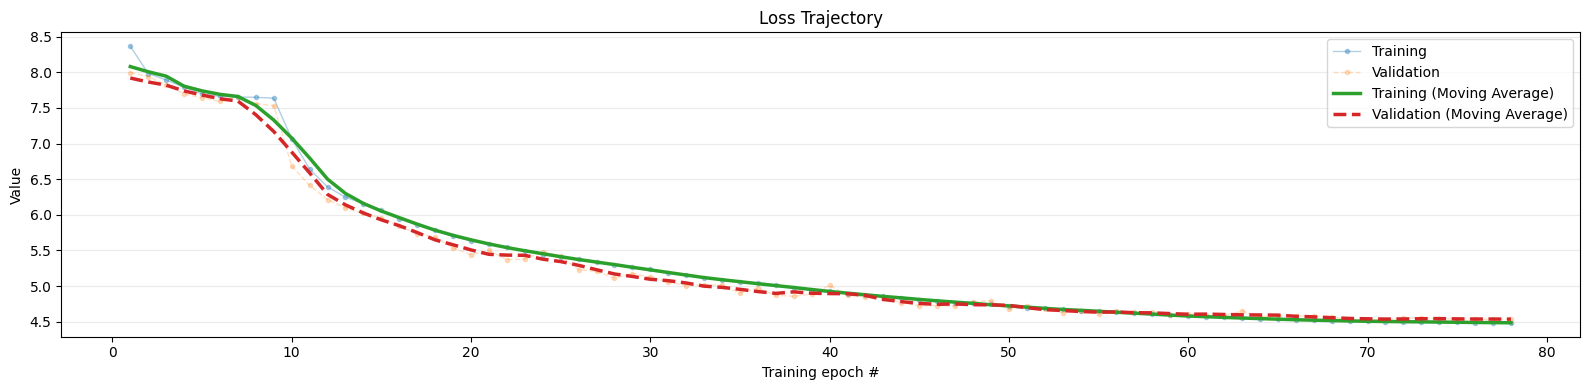

In [ ]:
# plot_loss_trajectory.py
# Reads Keras CSVLogger history or the saved NPY history dict and renders a
# "Loss Trajectory" chart with raw points + moving averages.

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1) Point to your saved history (CSV preferred; NPY works too)
# If you used the paths from your training script:
csv_path = Path("/content/drive/MyDrive/gw_dataset/gw_bbh_down4_train_history.csv")
npy_path = Path("/content/drive/MyDrive/gw_dataset/gw_bbh_down4_train_history.npy")  # fallback
out_png  = csv_path.with_name("gw_bbh_down4_loss_trajectory.png")

# ---- 2) Robust moving average (NaN-aware, centered)
def moving_average(x, window):
    x = np.asarray(x, dtype=float)
    if window < 2:
        return x
    w = int(window) | 1  # force odd window
    mask = ~np.isnan(x)
    num = np.convolve(np.where(mask, x, 0.0), np.ones(w), mode="same")
    den = np.convolve(mask.astype(float), np.ones(w), mode="same")
    return np.divide(num, np.maximum(den, 1e-12))

# ---- 3) Load history
if csv_path.exists():
    df = pd.read_csv(csv_path)
    # Keras CSVLogger usually has 'loss' and 'val_loss'
    loss     = df["loss"].to_numpy()
    val_loss = df["val_loss"].to_numpy() if "val_loss" in df else None
elif npy_path.exists():
    hist = np.load(npy_path, allow_pickle=True).item()
    loss     = np.array(hist.get("loss", []))
    val_loss = np.array(hist.get("val_loss", [])) if "val_loss" in hist else None
else:
    raise FileNotFoundError("Neither history CSV nor NPY found.")

epochs = np.arange(1, len(loss) + 1)

# ---- 4) Choose smoothing window (~5% of epochs, >=5)
win = max(5, int(round(0.05 * len(loss))) | 1)  # make it odd
loss_ma = moving_average(loss, win)
val_ma  = moving_average(val_loss, win) if val_loss is not None else None

# ---- 5) Plot (matplotlib only)
plt.figure(figsize=(16, 4))

# raw points
plt.plot(epochs, loss, marker="o", ms=3, lw=1, alpha=0.35, label="Training")
if val_loss is not None:
    plt.plot(epochs, val_loss, marker="o", ms=3, lw=1, alpha=0.25, linestyle="--", label="Validation")

# moving averages
plt.plot(epochs, loss_ma, lw=2.5, label="Training (Moving Average)")
if val_ma is not None:
    plt.plot(epochs, val_ma, lw=2.5, linestyle="--", label="Validation (Moving Average)")

plt.title("Loss Trajectory")
plt.xlabel("Training epoch #")
plt.ylabel("Value")
plt.grid(axis="y", alpha=0.25)
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()

# ---- 6) Save next to your history CSV
plt.savefig(out_png, dpi=180)
print(f"Saved plot → {out_png}")
plt.show()


In [ ]:
%%bash
# ONE-OFF at the top of your notebook, before Python starts
mkdir -p /content/tmp_data
cp -v /content/drive/MyDrive/gw_dataset/gw_bayesflow_approx.keras /content/tmp_data/


'/content/drive/MyDrive/gw_dataset/gw_bayesflow_approx.keras' -> '/content/tmp_data/gw_bayesflow_approx.keras'


Loaded: /content/tmp_data/gw_bbh_down4_val.npz
θ_val: (4000, 6)   x_val: (4000, 1, 8192)
→ Transposed to channels-last (N, T, 1).  New shape: (4000, 8192, 1)
→ Temporal mean-pooled ×2.  New shape: (4000, 4096, 1)
→ Loaded waveform scaler from: /content/drive/MyDrive/gw_dataset/gw_bbh_down4_wave_scaler_runtime.npz
Loaded model: /content/drive/MyDrive/gw_dataset/gw_bayesflow_approx.keras



=== Summary diagnostics (subset=True) ===
inference_variables_0         : NRMSE                    0.275299
Posterior Contraction    0.431601
Calibration Error        0.004035
Name: inference_variables_0, dtype: float64
inference_variables_1         : NRMSE                    0.151971
Posterior Contraction    0.778388
Calibration Error        0.012982
Name: inference_variables_1, dtype: float64
inference_variables_2         : NRMSE                    0.363329
Posterior Contraction    0.090135
Calibration Error        0.027719
Name: inference_variables_2, dtype: float64
inference_variables_3         : NRMSE                    0.363619
Posterior Contraction    0.000000
Calibration Error        0.017368
Name: inference_variables_3, dtype: float64
inference_variables_4         : NRMSE                    0.268217
Posterior Contraction    0.021100
Calibration Error        0.011842
Name: inference_variables_4, dtype: float64
inference_variables_5         : NRMSE                    0.335990
P

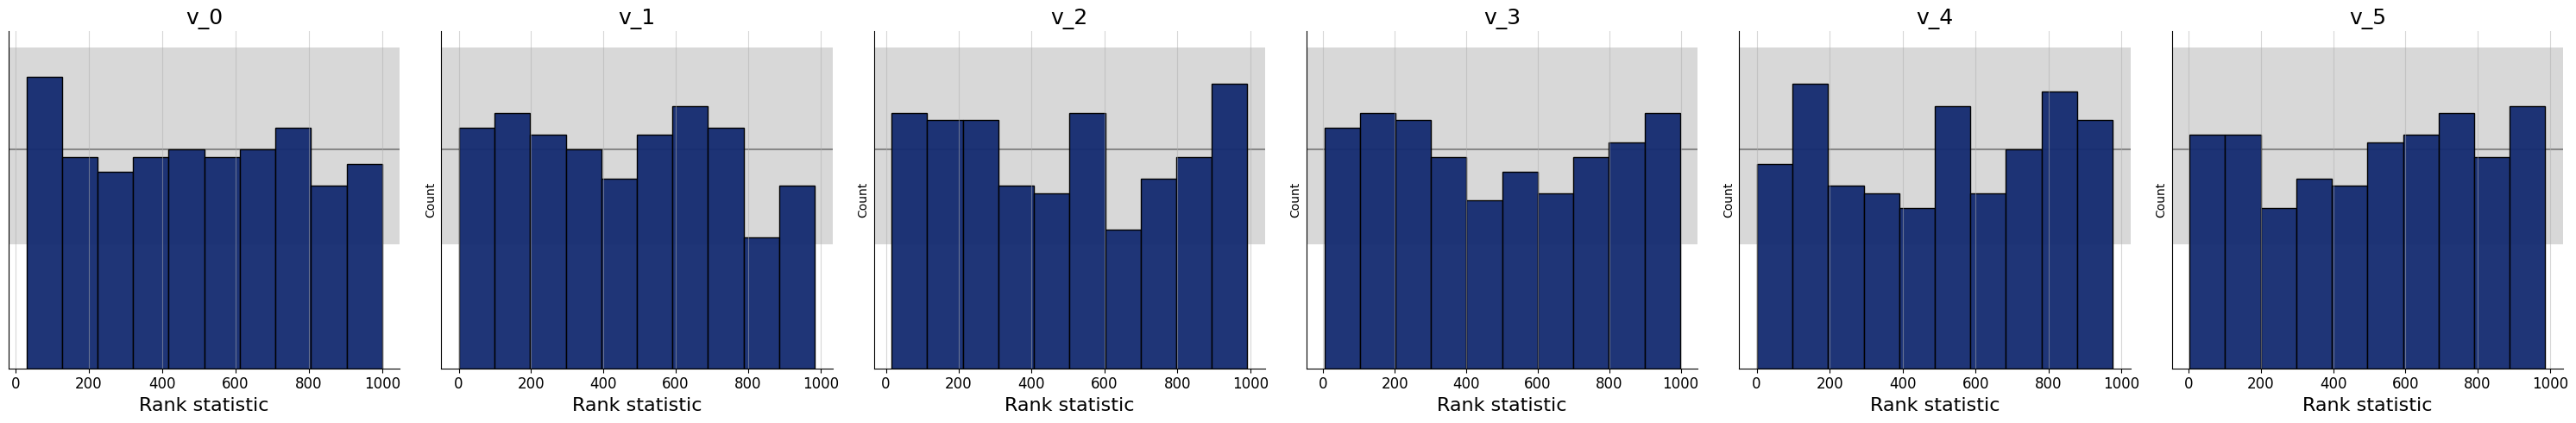

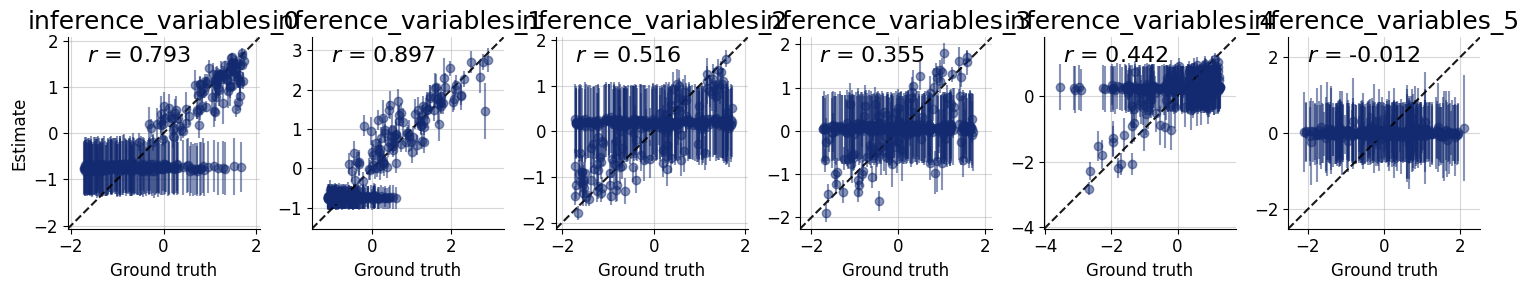

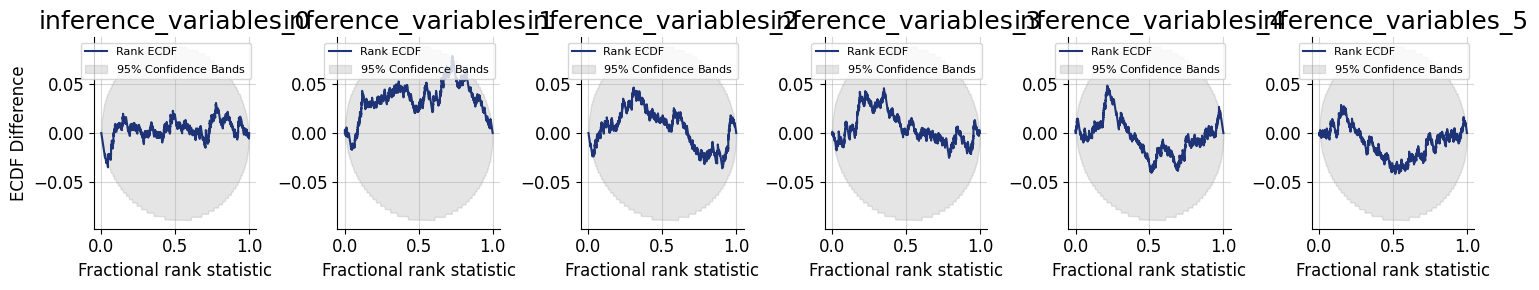

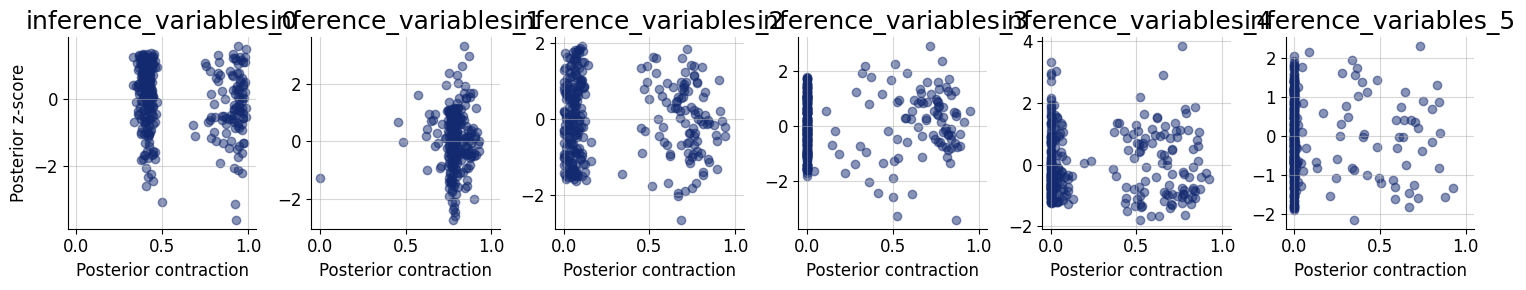

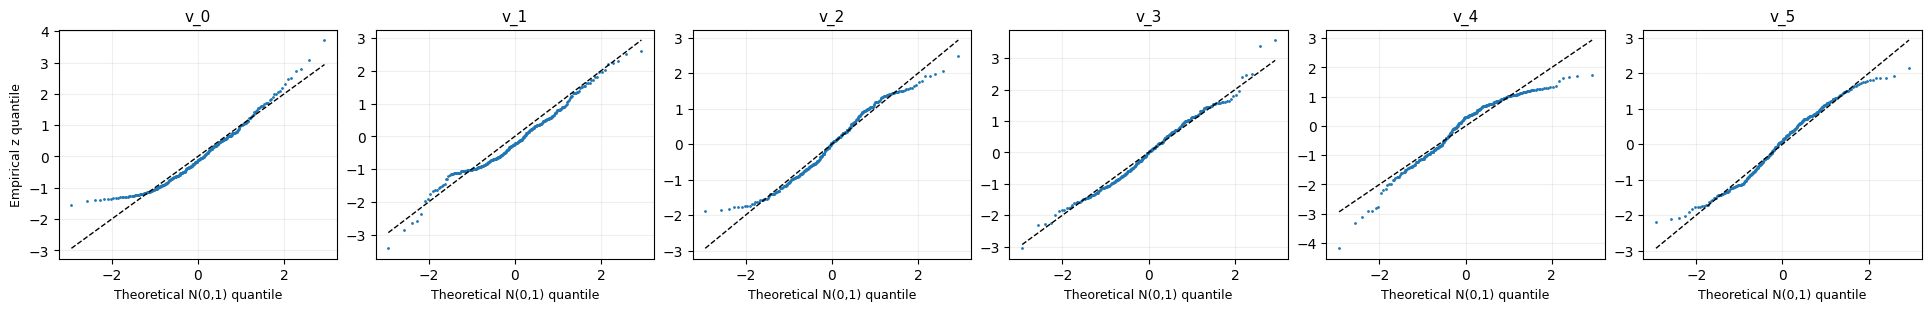

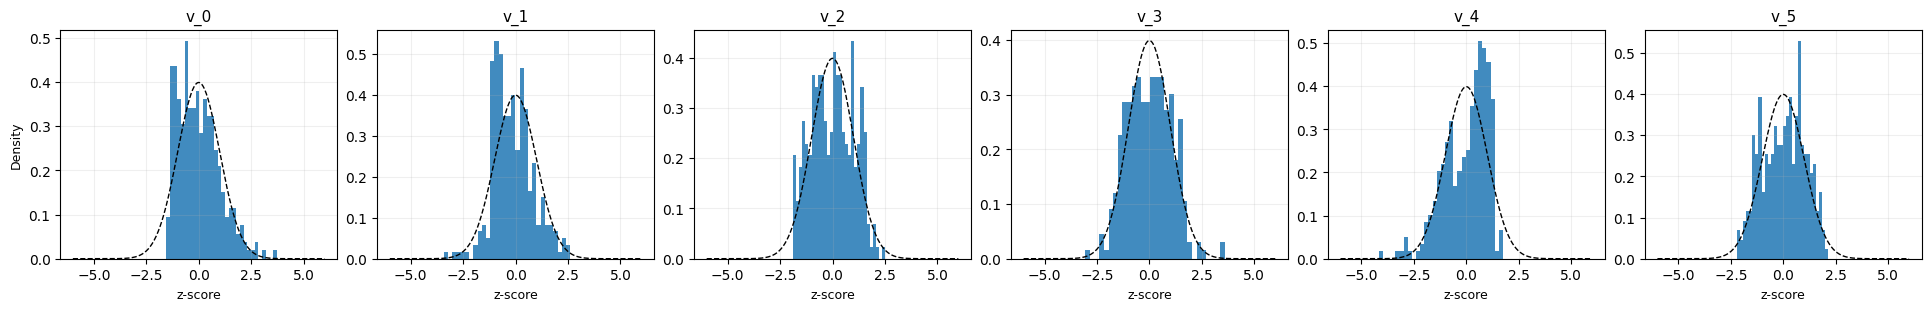

In [ ]:
#!/usr/bin/env python
"""
gw_bayesflow_diagnostics_down4_pf2.py
-------------------------------------------
• Data: 1024 Hz (down×4) + POOL_FACTOR=2
• Preproc: channels-last (N,T,1) → mean-pool ×2 → standardize (train scaler)
• Draw N_POST_DRAWS posterior samples on a subset and run diagnostics:
  - BayesFlow default suite (loss, recovery, ECDF, z-score contraction)
  - Calibration histogram (rank statistic)  <-- ADDED
  - z-score normality (QQ + histogram)      <-- ADDED
"""

# 0) Environment ---------------------------------------------------------------
import os, json
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from pathlib import Path
import numpy as np
from numpy.random import default_rng
import tensorflow as tf
import keras
import bayesflow as bf
from bayesflow.adapters import Adapter
from bayesflow.workflows import BasicWorkflow
from bayesflow.diagnostics import plots
from matplotlib import pyplot as plt

# Keep float32 to match the trained model
try:
    from keras import mixed_precision
    mixed_precision.set_global_policy("float32")
except Exception:
    pass

for gpu in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError:
        pass

# 1) Paths & constants ---------------------------------------------------------
PREFIX     = "gw_bbh_down4"   # 1024 Hz dataset
DRIVE_DIR  = Path("/content/drive/MyDrive/gw_dataset")
DATA_DIR   = Path("/content/tmp_data")

VAL_PATH   = DATA_DIR / f"{PREFIX}_val.npz"
MODEL_PATH = DRIVE_DIR / "gw_bayesflow_approx.keras"

SCALER_CANDIDATES = [
    DRIVE_DIR / f"{PREFIX}_wave_scaler_runtime.npz",
    DRIVE_DIR / f"{PREFIX}_wave_scaler.npz",
]
META_JSON  = DRIVE_DIR / f"{PREFIX}_preproc_meta.json"

USE_SUBSET     = True
TEST_N         = 300
N_POST_DRAWS   = 1_000
BATCH_SIZE_SMP = 128

# 2) Load val set ---------------------------------------------------------------
val        = np.load(VAL_PATH)
theta_val  = val["parameters"].astype(np.float32)
x_val      = val["waveforms"].astype(np.float32)

print(f"Loaded: {VAL_PATH}")
print(f"θ_val: {theta_val.shape}   x_val: {x_val.shape}")

# 3) Preprocessing (match training) --------------------------------------------
# channels last
if x_val.ndim == 3 and x_val.shape[1] == 1 and x_val.shape[-1] != 1:
    x_val = np.transpose(x_val, (0, 2, 1))
    print("→ Transposed to channels-last (N, T, 1).  New shape:", x_val.shape)
elif x_val.ndim == 2:
    x_val = x_val[:, :, None]
    print("→ Expanded to channels-last (N, T, 1).  New shape:", x_val.shape)

# mean-pool ×2
pool_factor = 2
try:
    if META_JSON.exists():
        meta = json.loads(META_JSON.read_text())
        pool_factor = int(meta.get("pool_factor", 2))
except Exception:
    pass

def mean_pool_1d(arr, k):
    N, T, C = arr.shape
    cut = (T // k) * k
    if cut != T:
        arr = arr[:, :cut, :]
    return arr.reshape(N, cut // k, k, C).mean(axis=2, dtype=np.float32)

x_val = mean_pool_1d(x_val, pool_factor)
print(f"→ Temporal mean-pooled ×{pool_factor}.  New shape:", x_val.shape)

# standardize with training scaler
wave_mean = None; wave_std = None
for cand in SCALER_CANDIDATES:
    if cand.exists():
        s = np.load(cand)
        wave_mean = np.array(s["mean"], dtype=np.float32)
        wave_std  = np.array(s["std"],  dtype=np.float32)
        print("→ Loaded waveform scaler from:", cand)
        break
if wave_mean is None or wave_std is None:
    wave_mean = x_val.mean(axis=(0,1), keepdims=True).astype(np.float32)
    wave_std  = x_val.std(axis=(0,1),  keepdims=True).astype(np.float32) + 1e-8
    print("⚠️  Scaler not found; using val-set mean/std (fallback).")

if wave_mean.ndim == 0:
    wave_mean = wave_mean[None, None, None]
    wave_std  = wave_std[None,  None,  None]
elif wave_mean.ndim == 1:
    wave_mean = wave_mean[None, None, :]
    wave_std  = wave_std[None,  None, :]

x_val = ((x_val - wave_mean) / wave_std).astype(np.float32)

# 4) Workflow + model -----------------------------------------------------------
adapter  = Adapter().rename("waveforms", "summary_variables").to_array()
workflow = BasicWorkflow(adapter=adapter, optimizer=None)
workflow.approximator = keras.saving.load_model(MODEL_PATH, compile=False)
print("Loaded model:", MODEL_PATH)

# 5) Posterior sampling ---------------------------------------------------------
def batched_sample(wf, waves, draws=1_000, batch=128):
    outs = []
    for i in range(0, len(waves), batch):
        slab = waves[i : i + batch]
        s    = wf.sample(num_samples=draws, conditions={"waveforms": slab})
        outs.append(s["inference_variables"])
    return np.concatenate(outs, axis=0)

if USE_SUBSET:
    rng         = default_rng(42)
    idx         = rng.choice(len(x_val), TEST_N, replace=False)
    x_test      = x_val[idx]
    theta_test  = theta_val[idx]
    samples     = workflow.sample(
        num_samples=N_POST_DRAWS, conditions={"waveforms": x_test}
    )["inference_variables"]
else:
    x_test      = x_val
    theta_test  = theta_val
    samples     = batched_sample(workflow, x_test, draws=N_POST_DRAWS, batch=BATCH_SIZE_SMP)

# 6) Diagnostics ---------------------------------------------------------------
# 6a) Calibration histogram (rank statistic)  <-- THIS produces the chart you want
fig_cal_hist = plots.calibration_histogram(samples, theta_test)

# 6b) BayesFlow default suite (no duplicates)
metrics = workflow.compute_default_diagnostics(
    test_data={"waveforms": x_test, "inference_variables": theta_test},
)
figures = workflow.plot_default_diagnostics(
    test_data                 = {"waveforms": x_test, "inference_variables": theta_test},
    loss_kwargs               = {"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs           = {"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs   = {"figsize": (15, 3), "legend_fontsize": 8,
                                 "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs= {"figsize": (15, 3), "label_fontsize": 12},
)

print(f"\n=== Summary diagnostics (subset={USE_SUBSET}) ===")
for key, val in metrics.items():
    try:
        print(f"{key:30s}: {float(val):.6f}")
    except (TypeError, ValueError):
        print(f"{key:30s}: {val}")

# 7) Added: z-score normality (QQ + histogram) ---------------------------------
def compute_z_scores(samps: np.ndarray, theta_true: np.ndarray) -> np.ndarray:
    mu  = samps.mean(axis=1)                      # (N, P)
    std = samps.std(axis=1, ddof=1) + 1e-8        # (N, P)
    return (theta_true - mu) / std                # (N, P)

# Use SciPy if available; otherwise a high-accuracy inverse normal fallback
try:
    from scipy.stats import norm
    def normal_quantiles(n: int) -> np.ndarray:
        p = (np.arange(1, n + 1) - 0.5) / n
        p = np.clip(p, 1e-12, 1 - 1e-12)
        return norm.ppf(p).astype(np.float64)
except Exception:
    def _inv_norm_cdf(p):
        p = np.asarray(p, dtype=np.float64)
        a = [-3.969683028665376e+01,  2.209460984245205e+02,
             -2.759285104469687e+02,  1.383577518672690e+02,
             -3.066479806614716e+01,  2.506628277459239e+00]
        b = [-5.447609879822406e+01,  1.615858368580409e+02,
             -1.556989798598866e+02,  6.680131188771972e+01,
             -1.328068155288572e+01]
        c = [-7.784894002430293e-03, -3.223964580411365e-01,
             -2.400758277161838e+00, -2.549732539343734e+00,
              4.374664141464968e+00,  2.938163982698783e+00]
        d = [ 7.784695709041462e-03,  3.224671290700398e-01,
              2.445134137142996e+00,  3.754408661907416e+00]
        plow, phigh = 0.02425, 1 - 0.02425
        q = np.zeros_like(p)
        m = p < plow
        if m.any():
            ql = np.sqrt(-2*np.log(p[m]))
            q[m] = (((((c[0]*ql + c[1])*ql + c[2])*ql + c[3])*ql + c[4])*ql + c[5]) / \
                    ((((d[0]*ql + d[1])*ql + d[2])*ql + d[3])*ql + 1)
        m = (p >= plow) & (p <= phigh)
        if m.any():
            r = p[m] - 0.5; t = r*r
            q[m] = (((((a[0]*t + a[1])*t + a[2])*t + a[3])*t + a[4])*t + a[5])*r / \
                    (((((b[0]*t + b[1])*t + b[2])*t + b[3])*t + b[4])*t + 1)
        m = p > phigh
        if m.any():
            qu = np.sqrt(-2*np.log(1 - p[m]))
            q[m] = -(((((c[0]*qu + c[1])*qu + c[2])*qu + c[3])*qu + c[4])*qu + c[5]) / \
                     ((((d[0]*qu + d[1])*qu + d[2])*qu + d[3])*qu + 1)
        return q
    def normal_quantiles(n: int) -> np.ndarray:
        p = (np.arange(1, n + 1) - 0.5) / n
        p = np.clip(p, 1e-12, 1 - 1e-12)
        return _inv_norm_cdf(p)

def plot_z_normality(z: np.ndarray, titles=None, max_abs=6.0):
    N, P = z.shape
    if titles is None:
        titles = [f"v_{j}" for j in range(P)]

    # QQ plots
    fig_qq, axs = plt.subplots(1, P, figsize=(3.2*P, 3.0), constrained_layout=True)
    axs = np.atleast_1d(axs)
    for j in range(P):
        zj = z[:, j]
        zj = zj[np.isfinite(zj)]
        zj = zj[np.abs(zj) <= max_abs]
        zj.sort()
        q = normal_quantiles(len(zj))
        ax = axs[j]
        ax.plot(q, zj, ".", ms=2)
        lo, hi = q[0], q[-1]
        ax.plot([lo, hi], [lo, hi], "k--", lw=1)
        ax.set_title(titles[j], fontsize=11)
        ax.set_xlabel("Theoretical N(0,1) quantile", fontsize=9)
        if j == 0: ax.set_ylabel("Empirical z quantile", fontsize=9)
        ax.grid(alpha=0.2)

    # Histograms
    from math import pi
    xs = np.linspace(-max_abs, max_abs, 512)
    pdf = np.exp(-0.5*xs*xs) / np.sqrt(2.0*pi)

    fig_hist, axs2 = plt.subplots(1, P, figsize=(3.2*P, 3.0), constrained_layout=True)
    axs2 = np.atleast_1d(axs2)
    for j in range(P):
        zj = z[:, j]
        zj = zj[np.isfinite(zj)]
        zj = zj[np.abs(zj) <= max_abs]
        ax = axs2[j]
        ax.hist(zj, bins=30, density=True, alpha=0.85)
        ax.plot(xs, pdf, "k--", lw=1)
        ax.set_title(titles[j], fontsize=11)
        ax.set_xlabel("z-score", fontsize=9)
        if j == 0: ax.set_ylabel("Density", fontsize=9)
        ax.grid(alpha=0.2)

    return fig_qq, fig_hist

def print_z_summary(z: np.ndarray, names=None):
    P = z.shape[1]
    if names is None: names = [f"v_{j}" for j in range(P)]
    print("\nPosterior z-score summary (mean ± std | skew | kurtosis_excess):")
    for j in range(P):
        zj = z[:, j]
        zj = zj[np.isfinite(zj)]
        if len(zj) == 0:
            print(f"  {names[j]:<18s}: (no finite values)")
            continue
        m  = float(zj.mean())
        s  = float(zj.std(ddof=1))
        if len(zj) > 3:
            c3 = float(((zj - m)**3).mean())
            c4 = float(((zj - m)**4).mean())
            skew = c3 / (s**3 + 1e-12)
            kurt = c4 / (s**4 + 1e-12) - 3.0
        else:
            skew = np.nan; kurt = np.nan
        print(f"  {names[j]:<18s}: {m:+.3f} ± {s:.3f} | skew {skew:+.3f} | kurt {kurt:+.3f}")

z_scores = compute_z_scores(samples, theta_test)
param_names = [f"v_{j}" for j in range(z_scores.shape[1])]
fig_qq, fig_hist = plot_z_normality(z_scores, titles=param_names)
print_z_summary(z_scores, names=param_names)

# Optional: save
# OUT_DIR = DRIVE_DIR / "diagnostics_down4_pf2"
# OUT_DIR.mkdir(parents=True, exist_ok=True)
# fig_cal_hist.savefig(OUT_DIR / "calibration_histogram.png", dpi=150, bbox_inches="tight")
# for name, fig in figures.items():
#     if hasattr(fig, "savefig"):
#         fig.savefig(OUT_DIR / f"{name}.png", dpi=150, bbox_inches="tight")
# fig_qq.savefig(OUT_DIR / "z_normality_qq.png", dpi=150, bbox_inches="tight")
# fig_hist.savefig(OUT_DIR / "z_normality_hist.png", dpi=150, bbox_inches="tight")
# print("Saved figures to:", OUT_DIR)
